In [1]:
from sys import path as sp
from pathlib import Path
from os import path

# Make scripts directory importable
sp.append(path.join((Path.cwd()).parent,"scripts"))

# Dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from filepaths import paths
from visualisers import plot_history, plot_activity_v2, plot_full_v2, plot_full_v3, plot_activity_v3
from dataloader_notebook import unlink_DStore, load_to_df, get_real_testdata, get_training_files

# Read Files & Set Column Names

In [3]:
# Self Training Data
trainfiles = get_training_files()
# testfiles = get_real_testdata()

train_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'Activity_code']
train_classes = ['exit','reload','grenade','shield','idle']
# test_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']

targetfiles = trainfiles
cols = train_cols

# targetfiles = unlink_DStore(targetfiles)

targetfiles

[PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/self/muthu/standing/IMU_glove1_muthu_standing_grenade (copy).txt'),
 PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/self/muthu/standing/IMU_glove2_muthu_stand_shield_modded.txt'),
 PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/self/muthu/standing/IMU_glove2_muthu_standing_grenade (copy).txt'),
 PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/self/muthu/standing/IMU_glove2_muthu_standing_reload (copy).txt'),
 PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/self/muthu/standing/IMU_glove1_muthu_standing_reload_lookviz (copy).txt'),
 PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/self/muthu/standing/IMU_glove1_muthu_standing_shield (copy).txt'),
 PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/self/muthu/standing/IMU_glove2_muthu_stand_shield_holds_modded.txt'),
 PosixPath('/Users/anderson/Desktop/github/capstoneml/datasets/self/muthu/walkin

In [4]:
df = load_to_df(targetfiles, cols)

# Remove ';'
df[train_cols[6]] = df[train_cols[6]].str.slice(start=0, stop=-1)

# Cleanup anomalies
df = df[df['Activity_code'].isin(train_classes)]
df[cols[:6]] = df[cols[:6]].astype('int')
df = df[(df[cols[:6]] <= 255).all(axis=1)]
df = df[(df[cols[:6]] >= 0).all(axis=1)]
# df = df[filter]
df['time']=[i+1 for i in range(df.shape[0])]
# df['gz'] = df['gz'].astype('int')

df

,ax,ay,az,gx,gy,gz,Activity_code,time
0,76,111,147,129,128,126,idle,1
1,76,111,147,129,128,126,idle,2
2,76,111,147,129,128,127,idle,3
3,76,111,147,129,128,127,idle,4
4,76,111,148,130,128,127,idle,5
...,...,...,...,...,...,...,...,...
10703,24,163,153,69,8,11,exit,591987
10705,83,183,135,8,205,70,exit,591988
10706,83,183,135,8,205,70,exit,591989
10707,149,41,138,147,72,246,exit,591990


# Feature Extraction

In [5]:
df_copy = df.copy()
timestep = 40

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


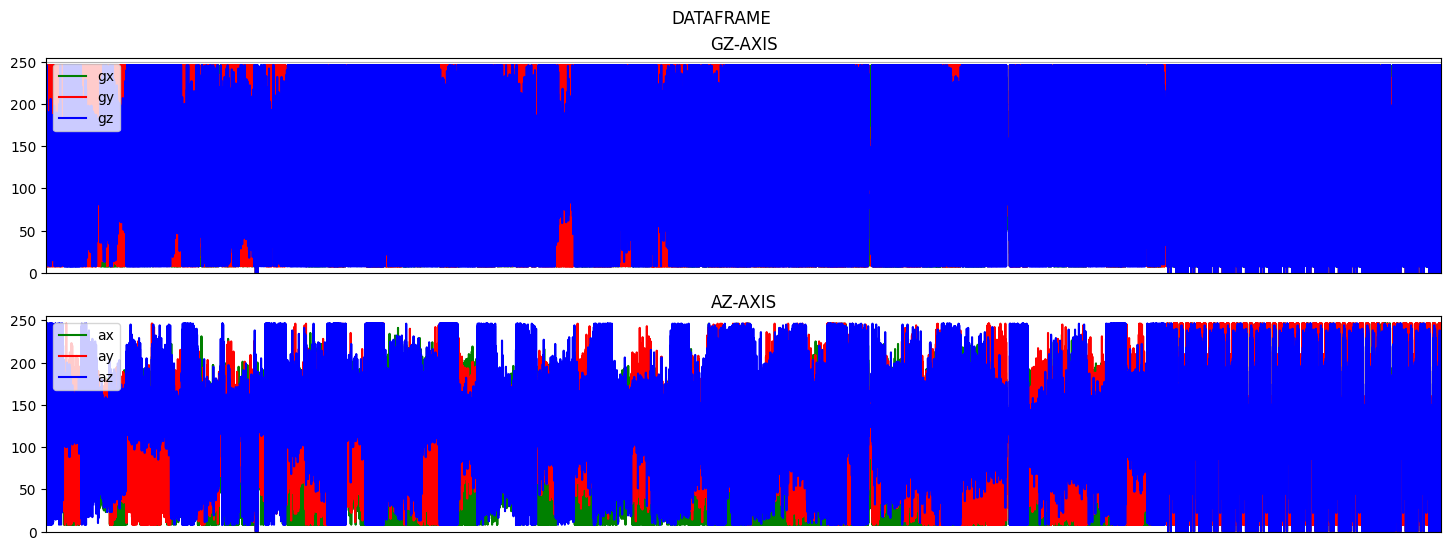

In [6]:
plot_full_v2(df_copy)

# Visualise Data

In [7]:
Fs=40
activities = df['Activity_code'].value_counts().index
print(activities)
df['Activity_code'].value_counts()

Index(['idle', 'grenade', 'exit', 'shield', 'reload'], dtype='object')


idle       349338
grenade     65999
exit        61689
shield      58449
reload      56516
Name: Activity_code, dtype: int64

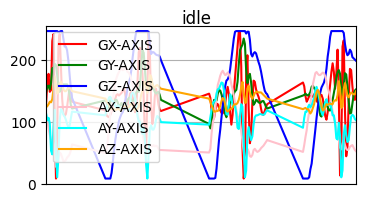

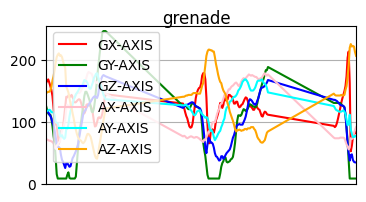

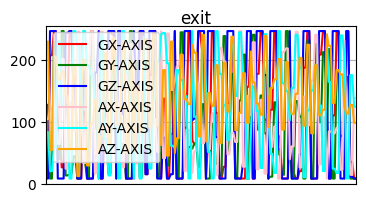

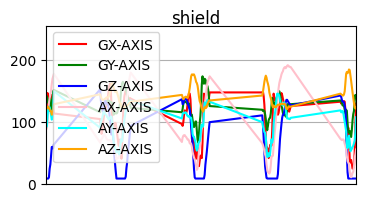

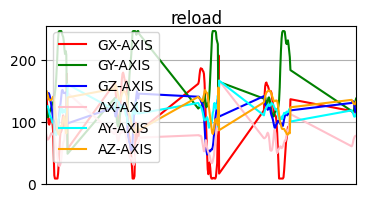

In [8]:
filt_df = df
for activity in activities:
    data_for_plot = filt_df[(filt_df['Activity_code'] == activity)][5250:5250+Fs*4]
    plot_activity_v3(activity, data_for_plot, figsize=(4,2))


In [9]:
# filt_df = filt_df.drop('Subject_id', axis=1)
filt_df = filt_df.drop('time', axis=1)

In [10]:
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from model_utils_training import encode, scale_255, scale_vals, scaled_data, get_frames,balance_frames

In [127]:
df_copy, label = encode(df_copy)

print(label.classes_)

['exit' 'grenade' 'idle' 'reload' 'shield']


In [12]:
data = scale_vals(df_copy)
ds_X = data[['ax','ay','az','gx','gy','gz']]
ds_Y = data['label']
scaled_X = pd.DataFrame(data=ds_X, columns=['ax','ay','az','gx','gy','gz'])
scaled_X['Activity_code'] = ds_Y.values

In [13]:
import scipy.stats as stats

In [14]:
seconds = 1
Fs = 40
frame_size = int(Fs*seconds/2) # 40 Hz * 1/2 (every half second check) = 20
hop_size = int(Fs*seconds/8) # hop every 5 steps

In [15]:
x, y = get_frames(scaled_X, frame_size, hop_size, labelled=True)
x.shape, y.shape

/Users/anderson/Desktop/github/capstoneml/scripts/model_utils_training.py:58: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(filt_df['Activity_code'][i: i + frame_size])[0][0]


((118395, 20, 6), (118395,))

In [16]:
bal_raw = 55000
bal_now = int(bal_raw/hop_size)

# x, y = balance_frames(x, y, bal_now, classes_n=3)
x, y = balance_frames(x, y, bal_now)

x.shape, y.shape

0: 11000 SAMPLES!!
1: 11000 SAMPLES!!
2: 18700 SAMPLES!!
3: 10978 SAMPLES!!
4: 11000 SAMPLES!!


((62678, 20, 6), (62678,))

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=1)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((50142, 20, 6), (12536, 20, 6), (50142,), (12536,))

In [18]:
BUFFER_SIZE=X_train.shape[0]
BATCH_SIZE=128
# features = Features({"label": ClassLabel(names=["negative", "positive"])})

# Turn numpy arrays into tf dataset
ds = tf.data.Dataset.from_tensor_slices((x,y))
val_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

val_ds = val_ds.cache()
val_ds = val_ds.shuffle(X_test.shape[0])
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(int(BATCH_SIZE/2))

# Cache te dataset
ds = ds.cache()
ds = ds.shuffle(BUFFER_SIZE)
ds = ds.batch(BATCH_SIZE)
# Reduce likelihood of bottlenecking
ds = ds.prefetch(int(BATCH_SIZE/2))

ds
val_ds.as_numpy_iterator().next()[0].shape


(128, 20, 6)

### MODEL BUILD

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam


In [20]:
model = Sequential()
model.add(Conv1D(20, 3, activation='relu', input_shape = X_train[0].shape))
# model.add(Dropout(0.4))

model.add(Conv1D(25, 4, activation='relu'))
# model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(24, activation='relu'))
# model.add(Dropout(0.5))

model.add(Dense(14, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(5, activation='softmax'))

In [85]:
model = Sequential()
model.add(Conv1D(20, 3, activation='relu', input_shape = X_train[0].shape))
model.add(Dropout(0.4))

model.add(Conv1D(24, 4, activation='relu'))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(20, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(5, activation='softmax'))

In [21]:
# model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 20)            380       
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 25)            2025      
                                                                 
 flatten (Flatten)           (None, 375)               0         
                                                                 
 dense (Dense)               (None, 24)                9024      
                                                                 
 dense_1 (Dense)             (None, 14)                350       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 7

In [22]:
history = model.fit(ds, epochs=2000, validation_data=val_ds, verbose=1)

Epoch 1/2000
 29/490 [>.............................] - ETA: 0s - loss: 1.5563 - accuracy: 0.2387  

2022-11-11 15:10:13.900300: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


490/490 [==============================] - 1s 2ms/step - loss: 1.4673 - accuracy: 0.3696 - val_loss: 1.2320 - val_accuracy: 0.5915
Epoch 2/2000
490/490 [==============================] - 1s 2ms/step - loss: 1.1932 - accuracy: 0.5117 - val_loss: 0.9605 - val_accuracy: 0.6778
Epoch 3/2000
490/490 [==============================] - 1s 2ms/step - loss: 1.0524 - accuracy: 0.5694 - val_loss: 0.8409 - val_accuracy: 0.7163
Epoch 4/2000
490/490 [==============================] - 1s 2ms/step - loss: 0.9677 - accuracy: 0.6105 - val_loss: 0.7594 - val_accuracy: 0.7381
Epoch 5/2000
490/490 [==============================] - 1s 2ms/step - loss: 0.9081 - accuracy: 0.6449 - val_loss: 0.7106 - val_accuracy: 0.7487
Epoch 6/2000
490/490 [==============================] - 1s 2ms/step - loss: 0.8651 - accuracy: 0.6630 - val_loss: 0.6726 - val_accuracy: 0.7548
Epoch 7/2000
490/490 [==============================] - 1s 2ms/step - loss: 0.8385 - accuracy: 0.6731 - val_loss: 0.6486 - val_accuracy: 0.7619
Epoch

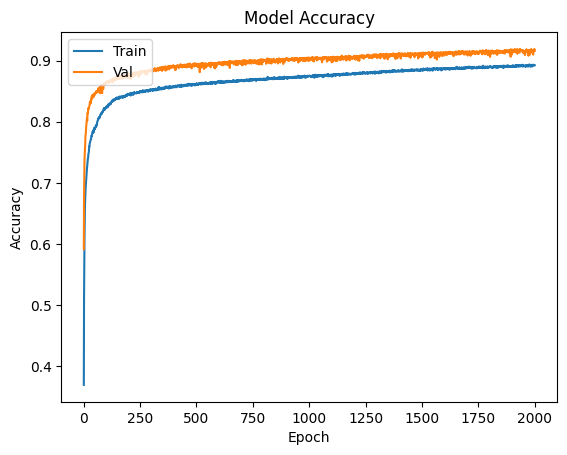

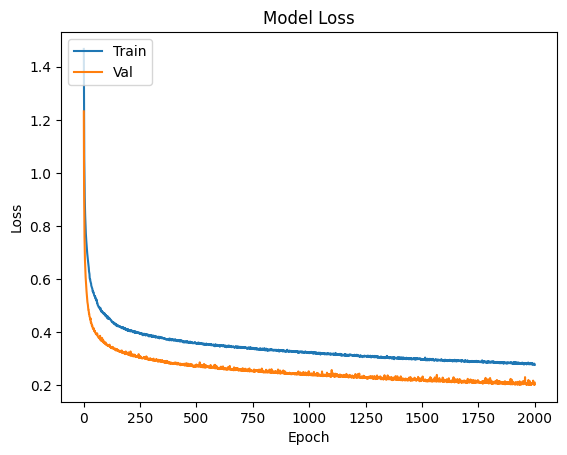

In [23]:
plot_history(history, 2000)

# Confusion Matrix

In [24]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [25]:
pred_x = X_test

y_pred = model.predict(pred_x)
classes_y = np.argmax(y_pred,axis=1)
chances = np.array([y_pred[i][np.argmax(y_pred[i])] for i in range(y_pred.shape[0])])
"""
for i in range(chances.shape[0]):
    if chances[i] < 0.95:
        print(0, end=" ")
    else:
        print(classes_y[i], end=" ")
"""

392/392 [==============================] - 0s 527us/step


'\nfor i in range(chances.shape[0]):\n    if chances[i] < 0.95:\n        print(0, end=" ")\n    else:\n        print(classes_y[i], end=" ")\n'

In [26]:
print(classes_y)

[1 2 4 ... 4 0 2]


(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

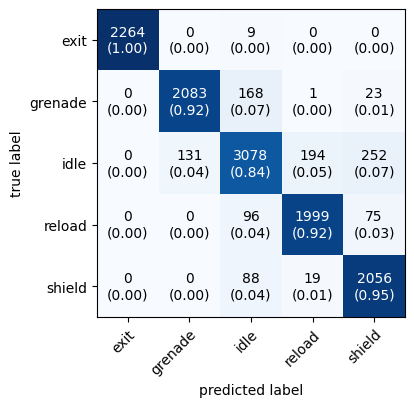

In [27]:
real_y = Y_test
# real_y = Y_test

mat = confusion_matrix(real_y, classes_y)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True,figsize=(4,4))


# Save Model

In [43]:
model_name = 'cnn-mix-final'
MODEL_DIR = Path(paths.get('MODEL_DIR'), f'{model_name}.h5')
model.save(MODEL_DIR)


# Load Model

In [21]:
model_name = 'cnn-mix-final'
MODEL_DIR = Path(paths.get('MODEL_DIR'), f'{model_name}.h5')
model = tf.keras.models.load_model(MODEL_DIR)


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 20)            380       
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 25)            2025      
                                                                 
 flatten (Flatten)           (None, 375)               0         
                                                                 
 dense (Dense)               (None, 24)                9024      
                                                                 
 dense_1 (Dense)             (None, 14)                350       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 7

# Move to Layers

In [40]:
w_0 = model.layers[0].get_weights()[0]
b_0 = model.layers[0].get_weights()[1]
w_1 = model.layers[1].get_weights()[0]
b_1 = model.layers[1].get_weights()[1]
w_2 = model.layers[3].get_weights()[0]
b_2 = model.layers[3].get_weights()[1]
w_3 = model.layers[4].get_weights()[0]
b_3 = model.layers[4].get_weights()[1]

final_w = model.layers[6].get_weights()[0]
final_b = model.layers[6].get_weights()[1]


In [41]:
# layers = np.array([conv2d_w_0,conv2d_b_0,conv2d_w_1,conv2d_b_1,dense_w_0,dense_b_0,dense_w_1,dense_b_1])

layers = np.array([w_0,b_0,w_1,b_1,w_2,b_2,w_3,b_3, final_w, final_b])

for i in layers:
    print(i.shape)

(3, 6, 20)
(20,)
(4, 20, 25)
(25,)
(375, 24)
(24,)
(24, 14)
(14,)
(14, 5)
(5,)


/var/folders/m6/ck_c1w1x74gdw0r9pf8n2knc0000gn/T/ipykernel_58718/4147205472.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  layers = np.array([w_0,b_0,w_1,b_1,w_2,b_2,w_3,b_3, final_w, final_b])


# Save Numpy

In [47]:
# outpath = paths.get('WEIGHT_DIR')
outpath = paths.get('MODEL_DIR')
outpath = Path(outpath, 'weights', 'cnn-mix-final')
# SAVE NP
save_np = layers

np.save(outpath, save_np)

In [34]:
dataframe = np.array([X_train, X_test, Y_train, Y_test])

outpath = paths.get('MODEL_DIR')
outpath = Path(outpath, 'weights', 'cnn-stand-df')

np.save(outpath, dataframe)

/var/folders/m6/ck_c1w1x74gdw0r9pf8n2knc0000gn/T/ipykernel_16659/639852206.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataframe = np.array([X_train, X_test, Y_train, Y_test])


# Implement CPU version

In [459]:
from cpu_implement import ml_process
# dense_test = X_test[0].reshape(120)
dense_test = X_test[1]
ml_process(dense_test, layers)

18
15
(4,)
[0.         0.91876486 0.         4.43290832]


# Visualise ML Layer Outputs

In [86]:
intermediate_layers = model.layers[:4]
intermediate_model = Sequential(intermediate_layers)
intermediate_model.build(input_shape=(None,20,6,1))
intermediate_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 20)            380       
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 25)            2025      
                                                                 
 flatten (Flatten)           (None, 375)               0         
                                                                 
 dense (Dense)               (None, 24)                9024      
                                                                 
Total params: 11,429
Trainable params: 11,429
Non-trainable params: 0
_________________________________________________________________


In [87]:
yhat = intermediate_model.predict(X_test[0:25])

1/1 [==============================] - 0s 37ms/step


In [88]:
viz = yhat[0]
print(viz.shape)
# print(viz)

(24,)


# Print Layers in Cpp

In [42]:
def printCpp(layer):
    wrap = layer.ndim
    if (wrap > 1):
        for i in range(len(layer)):
            print("{", end="")
            printCpp(layer[i])
            if i==len(layer)-1:
                print("}", end="")
            else:
                print("},", end=" \n")
    else:
        for i in range(len(layer)):
            if (i==(len(layer)-1)):
                print(layer[i],end="")
            else:
                print(layer[i],end=", ")


In [44]:
# i-=2
# toPrint = X_test[5:7].reshape(2,120)
# toPrint = Y_test[5:7]
toPrint = layers[7]

print("{", end="")
printCpp(toPrint)
print("};", end="\n")

{-0.043433458, -0.13623975, 0.040459383, -0.21980782, -0.052267715, 0.14719266, 0.25477365, 0.14838251, -0.13560803, -0.112702504, -0.11068837, 0.26310343, -0.05137562, -0.17719273};


In [15]:
idx = 4

processedList = []
toDlt = []
line_idxs = []

file = open(targetfiles[idx],"r")
print("opening file: ", targetfiles[idx])
lines = file.readlines()


for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[6].split(';')[0]
        last = last.strip()
        if last == '':
            break
        temp = [line[0], line[1], line[2], line[3], line[4], line[5], last]

        if last == 'exit':
            toDlt.append(i)
            print(i)
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

file.close()


file = open(targetfiles[idx],"w")
print("opening file: ", targetfiles[idx])

for i, line in enumerate(lines):
    try:
        if i not in toDlt:
            file.write(line)
    except:
        print('Error at line number: ', i)

file.close()


opening file:  /Users/anderson/Desktop/github/capstoneml/datasets/self/IMU_mingjun_exit_reload.txt
opening file:  /Users/anderson/Desktop/github/capstoneml/datasets/self/IMU_mingjun_exit_reload.txt
